# Detecting Independence of X and Y

In *Neural Conditional Probability for Uncertainty Quantification* (Kostic et al., 2024), the authors claim that the (deflated) conditional expectation operator can be used to detect the independence of two random variables X and Y by verifying whether it is zero. Here, we show this equivalence in practice. Specifically, we will learn the deflated operator $D_{Y \mid X}: L^2_Y \to L^2_X$ with a neural network $D_{Y\mid X}^\theta$ and then evaluate $\lVert D_{Y\mid X}^\theta \rVert$ to see if this quantity scales with the dependence of $X$ and $Y$.

## Dataset

We consider the data model

$$Y = tX + (1-t)X',$$

where $X$ and $X'$ are independent standard Gaussians in $\mathbb{R}$, and $t \in [0,1]$ is an interpolating factor. This model allows us to explore both extreme cases ($t = 0$ for independence and $t = 1$ where $Y = X$) and the continuum in between, to assess the robustness of NCP in detecting independence. In particular, we expect $\lVert D_{Y\mid X}^\theta \rVert \to 0$ as $t \to 0$.

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split


def make_dataset(n_samples: int = 200, t: float = 0.0):
    """Draw sample from data model Y = tX + (1-t)X_, where X and X_ are independent gaussians.

    If t = 0, then X and Y are independent. Otherwise, if t->1, X and Y become ever more dependent.

    Args:
        n_samples (int, optional): Number of samples. Defaults to 200.
        t (float, optional): Interpolation factor. Defaults to 0.0.
    """
    X = torch.normal(mean=0, std=1, size=(n_samples, 1))
    X_ = torch.normal(mean=0, std=1, size=(n_samples, 1))
    Y = t * X + (1 - t) * X_

    ds = TensorDataset(X, Y)

    # Split data into train and val sets
    train_ds, val_ds = random_split(ds, lengths=[0.85, 0.15])

    return train_ds, val_ds

## Learning the (Deflated) Conditional Expectation Operator

Let's go through the process of learning the deflated conditional expectation operator $D_{Y \mid X}: L^2_Y \mapsto L^2_X$, defined as

$$[D_{Y \mid X}g](x) = \mathbb{E}[g(Y) - \mathbb{E}[g(Y)] \mid X = x],$$

where $g \in L^2_Y$. In words, this operator computes the centered conditional expectation of $g(Y)$ given $X = x$.

### The Operator Linearizes Inference

# TODO: Add Example on usefulness.

### A Matrix Perspective
If we had access to orthonormal bases $\{u_i\}_{i=1}^\infty$ and $\{v_j\}_{j=1}^\infty$ of $L^2_X$ and $L^2_Y$ [(see Wikipedia)](https://en.wikipedia.org/wiki/Orthonormal_basis), we could see $D_{Y\mid X}$ as an (infinite) matrix $\mathbf{D}$ with entries:

$$\mathbf{D}_{ij} = \langle u_i, D_{Y \mid X}v_j \rangle_{L^2_X}.$$

Expanding this expectation, we get:

$$\mathbf{D}_{ij} = \mathbb{E}_X[u_i(X)([\mathbb{E}_{Y \mid X}v_j](X) - \mathbb{E}_Y[v_j(Y)])] = \mathbb{E}_{XY}[u_i(X)v_j(Y)] - \mathbb{E}_X[u_i(X)]\mathbb{E}_Y[v_j(Y)].$$

So, the matrix form of $D_{Y\mid X}$ is just the centered covariance between the (infinite-dimensional) latent variables $u(X)$ and $v(Y)$. Informally, we can write this as:

$$\text{Cov}(u, v) = \mathbb{E}_{XY}[(u-\mathbb{E}[u])(v-\mathbb{E}[v])^T] = \mathbf{D}.$$

### Learning the Operator in Finite Dimensions

Hence, to learn $D_{Y|X}$, we could "just" approximate its matrix coefficients within "good" finite-dimensional subspaces of $L^2_Y$ and $L^2_X$. That is, we could search for orthonormal functions  $\{u_i\}_{i=1}^d$ and $\{v_j\}_{j=1}^d$ that minimize:

$$\lVert D_{Y \mid X} - D_{Y \mid X}^d \rVert,$$

where $D_{Y \mid X}^d$ is the truncated operator acting on $\text{span}\{v_j\}_{j=1}^d$ and $\text{span}\{u_i\}_{i=1}^d$.


### Theoretical Solution via SVD

The problem of finiding low-rank approximations of matrices and operators is well studied [(see Wikipedia)](https://en.wikipedia.org/wiki/Low-rank_approximation). A key result is the Eckart-Young-Mirsky Theorem, which states that the optimum low-rank approximation (w.r.t. any unitary-invariant norm, like the operator or Hilbert-Schmidt norms) is achieved by the truncated Singular Value Decomposition (SVD):

$$D^d_{Y\mid X} = \sum_{i=1}^d \sigma_i u^*_i \otimes v^*_j,$$

where $u \otimes v$ is the rank-1 operator that maps $v' \mapsto u\langle v, v'\rangle$. In $\mathbb{R}^d$, this is just $uv^T$. The only difference from the SVD of $\mathbb{E}_{Y\mid X}$ is that the first singular triplet $(\sigma_0, u^*_0, v^*_0) = (1, 1, 1)$ is removed by the deflation/centering.

# TODO: This is just motivation/the singular functions might be badly approximated by NNs

### A Representation Learning Perspective

Now, let's shift our viewpoint slightly. Representation learning is all about finding embeddings or feature maps—functions that map inputs into a useful latent space. Formally, we seek functions $u^\theta: \mathcal{X} \to \mathbb{R}^d$ and $v^\theta: \mathcal{Y} \to \mathbb{R}^d$ that extract relevant features.

In this context, instead of explicitely constructing orthonormal functions, we can focus on learning whitened [(see Wikipedia)](https://en.wikipedia.org/wiki/Whitening_transformation) features, meaning that the $u^\theta_i$ are normalized and uncorrelated (similarly for $v^\theta$). A natural approach is to parameterize $u$ and $v$ using neural networks and optimize:

$$\mathcal{L}_\text{HS}(\theta) = \frac{1}{2}\lVert D_{Y \mid X} - D_{Y \mid X}^\theta \rVert_\text{HS}^2,$$

with gradient-based methods, where $D^\theta_{Y\mid X}$ is the empirical estimate.

### Hilbert-Schmidt Loss as a Contrastive Objective

# TODO: Missing derivation of equivalence (and Centering)

From a deep learning perspective, the Hilbert-Schmidt loss might seem a bit odd. However, a key insight from Kostic et al. (2024) is that it can be rewritten in a contrastive form:


$$\mathcal{L}_\text{HS}(\theta) = \frac{1}{2}\mathbb{E}_X\mathbb{E}_Y[\langle u^\theta(X), S^\theta v^\theta(Y)\rangle^2] - \mathbb{E}_{XY}[\langle u^\theta(X), S^\theta v^\theta(Y)\rangle],$$

where $S \in \mathbb{R}^{d\times d}$ is a learnable matrix representing the truncated operator's matrix form on the "bases" $\{u_i^\theta\}_{i=1}^d$ and $\{v_j^\theta\}_{j=1}^d$.

The empirical counterpart of this loss is:

$$\widehat{\mathcal{L}}_\text{HS}(\theta) = \frac{1}{2N(N-1)}\sum_{k \neq l}^N\langle u^\theta(x_k), S^\theta v^\theta(y_{l}) \rangle^2 - \frac{1}{N}\sum_{k=1}^N\langle u^\theta(x_{k}), S^\theta v^\theta(y_{k}) \rangle.$$

Here, $N$ is the batch size. Notice the first term cleverly increases the sample size using a U-statistic, a classic trick in statistics to reduce variance.



## Representation learning in practice

In [2]:
import math

import torch
from torch import Tensor
from torch.nn import Module


class _Matrix(Module):
    """Module representing the matrix form of the truncated conditional expectation operator."""

    def __init__(
        self,
        dim_u: int,
        dim_v: int,
    ) -> None:
        super().__init__()
        self.weights = torch.nn.Parameter(
            torch.normal(mean=0.0, std=2.0 / math.sqrt(dim_u * dim_v), size=(dim_u, dim_v))
        )

    def forward(self, v: Tensor) -> Tensor:
        """Forward pass of the truncated conditional expectation operator's matrix (v -> Sv)."""
        # TODO: Unify Pietro, Giacomo and Dani's ideas on how to normalize\symmetrize the operator.
        out = v @ self.weights.T
        return out


class NCP(Module):
    """Neural Conditional Probability in PyTorch.

    Args:
        embedding_x (Module): Neural embedding of x.
        embedding_dim_x (int): Latent dimension of x.
        embedding_y (Module): Neural embedding of y.
        embedding_dim_y (int): Latent dimension of y.
    """

    def __init__(
        self,
        embedding_x: Module,
        embedding_y: Module,
        embedding_dim_x: int,
        embedding_dim_y: int,
    ) -> None:
        super().__init__()
        self.U = embedding_x
        self.V = embedding_y

        self.dim_u = embedding_dim_x
        self.dim_v = embedding_dim_y

        self.S = _Matrix(self.dim_u, self.dim_v)

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        """Forward pass of NCP."""
        u = self.U(x)
        v = self.V(y)
        Sv = self.S(v)

        return u, Sv

## Training

We now show how to train the NCP module using the aforementioned contrastive loss and standard deep learning techniques.

In [3]:
from torch.optim import Optimizer
from linear_operator_learning.nn import L2ContrastiveLoss


def train(
    ncp: NCP,
    train_dataloader: DataLoader,
    device: str,
    loss_fn: callable,
    gamma: float,
    optimizer: Optimizer,
) -> Tensor:
    """Training logic of NCP."""
    ncp.train()
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        u, Sv = ncp(x, y)

        loss = loss_fn(u, Sv)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

In [4]:
import torch
from linear_operator_learning.nn import MLP
from linear_operator_learning.nn.linalg import whitening

SEED = 1
REPEATS = 1
BATCH_SIZE = 256
N_SAMPLES = 5000
MLP_PARAMS = dict(
    output_shape=2,
    n_hidden=2,
    layer_size=32,
    activation=torch.nn.ELU,
    bias=False,
    iterative_whitening=False,
)
EPOCHS = 100
WHITENING_N_SAMPLES = 2000

torch.manual_seed(SEED)

# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

results = dict()
for t in torch.linspace(start=0, end=1, steps=11):
    for r in range(REPEATS):
        run_id = (round(t.item(), 2), r)
        print(f"run_id = {run_id}")

        # Load data_________________________________________________________________________________
        train_ds, val_ds = make_dataset(n_samples=N_SAMPLES, t=t.item())

        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
        val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

        # Build NCP_________________________________________________________________________________
        ncp = NCP(
            embedding_x=MLP(input_shape=1, **MLP_PARAMS),
            embedding_dim_x=MLP_PARAMS["output_shape"],
            embedding_y=MLP(input_shape=1, **MLP_PARAMS),
            embedding_dim_y=MLP_PARAMS["output_shape"],
        ).to(device)

        # Train NCP_________________________________________________________________________________
        loss_fn = L2ContrastiveLoss()
        optimizer = torch.optim.Adam(ncp.parameters(), lr=5e-4)

        for epoch in range(EPOCHS):
            train(ncp, train_dl, device, loss_fn, 1e-3, optimizer)

        # Extract norm______________________________________________________________________________
        x = torch.normal(mean=0, std=1, size=(WHITENING_N_SAMPLES, 1)).to(device)
        x_ = torch.normal(mean=0, std=1, size=(WHITENING_N_SAMPLES, 1)).to(device)
        y = t * x + (1 - t) * x_
        u, Sv = ncp(x, y)

        _, _, svals, _, _ = whitening(u, Sv)
        results[run_id] = svals.max().item()

Using cpu device
run_id = (0.0, 0)
run_id = (0.1, 0)
run_id = (0.2, 0)
run_id = (0.3, 0)
run_id = (0.4, 0)
run_id = (0.5, 0)
run_id = (0.6, 0)
run_id = (0.7, 0)
run_id = (0.8, 0)
run_id = (0.9, 0)
run_id = (1.0, 0)


## Plots

<Axes: xlabel='t', ylabel='norm'>

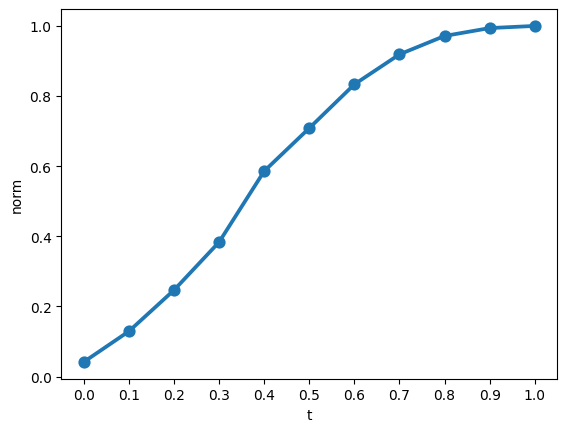

In [5]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame(
    data=[(t, r, norm) for ((t, r), norm) in results.items()],
    columns=["t", "r", "norm"],
)
sns.pointplot(results_df, x="t", y="norm")